In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../forecaster')
import mr_forecast as mr

%matplotlib inline

df = pd.read_csv('exoarchive.csv')
df.shape

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(26268, 296)

In [3]:
df.head()

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,default_flag,sy_snum,sy_pnum,...,sy_kepmagerr1,sy_kepmagerr2,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_ntranspec,st_nspec
0,1,11 Com b,11 Com,b,NaN,HIP 60202 b,TIC 72437047 b,1,2,1,...,NaN,NaN,2014-05-14,2008-01,2014-05-14,2,0,2,0,0
1,2,11 Com b,11 Com,b,NaN,HIP 60202 b,TIC 72437047 b,0,2,1,...,NaN,NaN,2014-07-23,2011-08,2014-07-23,2,0,2,0,0
2,3,11 UMi b,11 UMi,b,NaN,HIP 74793 b,TIC 230061010 b,0,1,1,...,NaN,NaN,2018-04-25,2009-10,2018-04-25,0,0,1,0,0
3,4,11 UMi b,11 UMi,b,NaN,HIP 74793 b,TIC 230061010 b,1,1,1,...,NaN,NaN,2018-09-04,2017-03,2018-09-04,0,0,1,0,0
4,5,11 UMi b,11 UMi,b,NaN,HIP 74793 b,TIC 230061010 b,0,1,1,...,NaN,NaN,2018-04-25,2011-08,2018-04-25,0,0,1,0,0


In [13]:
df[df['pl_name']=='Kepler-23 d'][['pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_refname']]

,pl_rade,pl_radeerr1,pl_radeerr2,pl_refname
13365,2.280,0.070,-0.070,<a refstr=Q1_Q16_KOI_TABLE href=https://exopla...
13366,2.175,0.111,-0.099,<a refstr=BERGER_ET_AL__2018 href=https://ui.a...
13367,2.200,0.070,-0.070,<a refstr=HADDEN_ET_AL__2014 href=https://ui.a...
13368,2.810,0.720,-0.720,<a refstr=Q1_Q8_KOI_TABLE href=https://exoplan...
13369,NaN,NaN,NaN,<a refstr=HOLCZER_ET_AL__2016 href=https://ui....
13370,2.170,0.130,-0.090,<a refstr=Q1_Q17_DR25_KOI_TABLE href=https://e...
13371,2.235,0.088,-0.088,<a refstr=VAN_EYLEN___ALBRECHT_2015 href=https...
13372,2.280,0.070,-0.070,<a refstr=Q1_Q12_KOI_TABLE href=https://exopla...
13373,2.280,0.070,-0.070,<a refstr=Q1_Q17_DR24_KOI_TABLE href=https://e...
13374,NaN,NaN,NaN,<a refstr=GAJDO_SCARON__ET_AL__2019 href=https...


In [14]:
Nplanetmin = 3
df = df[df['sy_pnum']>=Nplanetmin]
df.shape

(6460, 296)

In [3]:
def singlerowwithradius(df, name):
    copies = df[df['pl_name']==name]
    # take row with min error on radius
    raderrs = copies['pl_radeerr1'][copies['pl_radeerr1'] > 0]
    if raderrs.shape[0] > 0: # a row with nonzero errors exists
        row = copies[copies['pl_radeerr1'] == raderrs.min()].iloc[0]
        row['my_rade'] = row['pl_rade']
        row['my_rade_ref'] = row['pl_refname']
    else:
        masserrs = copies['pl_masseerr1'][copies['pl_masseerr1'] > 0]
        if masserrs.shape[0] > 0: # a row with nonzero errors exists
            row = copies[copies['pl_masseerr1'] == masserrs.min()].iloc[0]
            row['my_masse'] = row['pl_masse']
            row['my_masse_ref'] = row['pl_refname']
        else:
            msinierrs = copies['pl_msinieerr1'][copies['pl_msinieerr1'] > 0]
            if msinierrs.shape[0] > 0: # a row with nonzero errors exists
                row = copies[copies['pl_msinieerr1'] == msinierrs.min()].iloc[0]
                row['my_msinie'] = row['pl_msinie']
                row['my_msinie_ref'] = row['pl_refname']
                row['my_masse'] = row['my_msinie']/0.866 # divide msini by median sini = 0.866 for isotropic distribution
            else:
                print(name, 'No errors reported on radius, mass or msini')
                return None
    
    try:
        row['my_rade']
    except:
        row['my_rade'] = np.median(mr.Mpost2R([row['my_masse']]*100, unit='Earth')) # median of 100 samples from forecaster
    try:
        row['my_masse']
    except:
        row['my_masse'] = np.median(mr.Rpost2M([row['my_rade']]*100, unit='Earth')) # median of 100 samples from forecaster
        
    eccerrs = copies['pl_orbeccenerr1'][copies['pl_orbeccenerr1'] > 0]
    if eccerrs.shape[0] > 0: # a row with nonzero errors exists
        row_mineccerr = copies[copies['pl_orbeccenerr1'] == eccerrs.min()].iloc[0]
        row['my_ecc'] = row_mineccerr['pl_orbeccen']
        row['my_eccerr1'] = row_mineccerr['pl_orbeccenerr1']
        row['my_ecc_refname'] = row_mineccerr['pl_refname']
    else:
        pass
    
    perrs = copies['pl_orbpererr1'][copies['pl_orbpererr1'] > 0]
    if perrs.shape[0] > 0: # a row with nonzero errors exists
        row_minperr = copies[copies['pl_orbpererr1'] == perrs.min()].iloc[0]
        row['my_orbper'] = row_minperr['pl_orbper']
        row['my_orbper_refname'] = row_minperr['pl_refname']
    else:
        pass
    
    stmasserrs = copies['st_masserr1'][copies['st_masserr1'] > 0]
    if stmasserrs.shape[0] > 0: # a row with nonzero errors exists
        row_minstmasserr = copies[copies['st_masserr1'] == stmasserrs.min()].iloc[0]
        row['my_stmass'] = row_minstmasserr['st_mass']
        row['my_stmass_refname'] = row_minstmasserr['st_refname']
    else:
        print(name, 'No stellar mass')
        return None
    
    return row

In [4]:
%%time
dfunique = pd.DataFrame()
for name in df['pl_name'].unique():
    dfunique=dfunique.append(singlerowwithradius(df, name))
# Not all entries have smax, and makes sure period and stmass are consistent
dfunique['my_orbsmax'] = dfunique['my_stmass']**(1/3.)*(dfunique['my_orbper']/365)**(2/3.)

GJ 163 b No stellar mass
GJ 163 c No stellar mass
GJ 163 d No stellar mass
GJ 180 b No stellar mass
GJ 180 c No stellar mass
GJ 180 d No stellar mass
GJ 3138 b No stellar mass
GJ 3138 c No stellar mass
GJ 3138 d No stellar mass
GJ 3293 b No stellar mass
GJ 3293 c No stellar mass
GJ 3293 d No stellar mass
GJ 3293 e No stellar mass
GJ 433 c No stellar mass
GJ 433 d No stellar mass
GJ 676 A c No stellar mass
HD 133131 A b No stellar mass
HD 133131 A c No stellar mass
HD 133131 B b No stellar mass
HD 136352 b No stellar mass
HD 136352 c No stellar mass
HD 136352 d No stellar mass
HD 160691 d No errors reported on radius, mass or msini
HD 160691 e No errors reported on radius, mass or msini
HD 181433 b No errors reported on radius, mass or msini
HD 181433 c No errors reported on radius, mass or msini
HD 181433 d No errors reported on radius, mass or msini
HD 20781 b No stellar mass
HD 20781 c No stellar mass
HD 20781 d No stellar mass
HD 20781 e No stellar mass
HD 27894 b No stellar mass
HD

In [5]:
dfunique['my_orbper'].isnull().sum()

0

In [6]:
dfunique[['pl_orbsmax', 'my_orbsmax']].head()

,pl_orbsmax,my_orbsmax
43,2.100000,2.105616
46,3.600000,3.569657
47,11.600000,11.597564
55,0.115227,0.115246
67,0.241376,0.241266


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


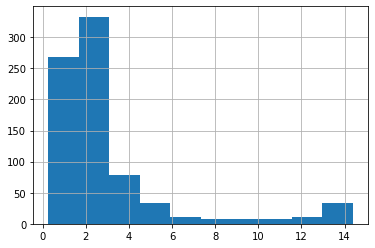

In [7]:
dfunique['my_rade'].hist()

In [8]:
dfunique[dfunique['my_rade']<4].shape[0]/dfunique.shape[0]

0.8434343434343434

In [9]:
# lost 12 systems to no stellar mass and 4 to no rad, pl mass or msini (< 10%)
Nsys = len(dfunique['hostname'].unique())
Nsys

226

In [10]:
Nplanet = dfunique.shape[0]
Nplanet

792

In [11]:
%%time
pratiothresh = 2.0
Mearth = 3.e-6 # solar masses
exclude = ['K2-148'] # orb periods don't match between different papers, names mixed up?
minPs = []
final = pd.DataFrame()
for ID in dfunique['hostname'].unique():
    s = dfunique[dfunique['hostname'] == ID].sort_values('my_orbper')
    Np = s.shape[0]
    if Np < Nplanetmin:
        continue
    if ID in exclude:
        continue
        
    Ncompactpairs = 0
    for i in range(Np-1):
        pratio = s.iloc[i+1]['my_orbper']/s.iloc[i]['my_orbper']
        if pratio < pratiothresh:
            Ncompactpairs += 1
    compact = True if Ncompactpairs >= 2 else False # DEFINED COMPACT AS HAVING AT LEAST A TRIO WITH PRATIOS < pratiothresh
    if compact:
        minPs.append(s.iloc[0]['my_orbper'])
    
    for i, (ID, row) in enumerate(s.iterrows()):
        row['my_compact'] = compact
        row['my_Np'] = Np
        if i > 0:
            RHi = s.iloc[i-1]['my_orbsmax']*((s.iloc[i-1]['my_masse'] + s.iloc[i]['my_masse'])*Mearth/3./s.iloc[i]['my_stmass'])**(1/3.)
            row['Delta_i'] = (s.iloc[i]['my_orbsmax']-s.iloc[i-1]['my_orbsmax'])/RHi
            row['Pratio_i'] = s.iloc[i]['my_orbper']/s.iloc[i-1]['my_orbper']
            row['ecross_i'] = (s.iloc[i]['my_orbsmax']-s.iloc[i-1]['my_orbsmax'])/s.iloc[i]['my_orbsmax']
        else:
            row['Delta_i'] =  np.nan
            row['Pratio_i'] = np.nan
            row['ecross_i'] = np.nan
        if i < Np-1:
            RHo = s.iloc[i]['my_orbsmax']*((s.iloc[i]['my_masse'] + s.iloc[i+1]['my_masse'])*Mearth/3./s.iloc[i]['my_stmass'])**(1/3.)
            row['Delta_o'] = (s.iloc[i+1]['my_orbsmax']-s.iloc[i]['my_orbsmax'])/RHo
            row['Pratio_o'] = s.iloc[i+1]['my_orbper']/s.iloc[i]['my_orbper']
            row['ecross_o'] = (s.iloc[i+1]['my_orbsmax']-s.iloc[i]['my_orbsmax'])/s.iloc[i]['my_orbsmax']
        else:
            row['Delta_o'] = np.nan
            row['Pratio_o'] =  np.nan
            row['ecross_o'] = np.nan

        row['Delta_min'] = np.nanmin([row['Delta_i'], row['Delta_o']])
        row['Pratio_min'] = np.nanmin([row['Pratio_i'], row['Pratio_o']])
        row['ecross_min'] = np.nanmin([row['ecross_i'], row['ecross_o']])
        final = final.append(row)

CPU times: user 32.4 s, sys: 205 ms, total: 32.7 s
Wall time: 32.7 s


(array([44., 22.,  6.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([ 0.658524 ,  5.5101716, 10.3618192, 15.2134668, 20.0651144,
        24.916762 , 29.7684096, 34.6200572, 39.4717048, 44.3233524,
        49.175    ]),
 <a list of 10 Patch objects>)

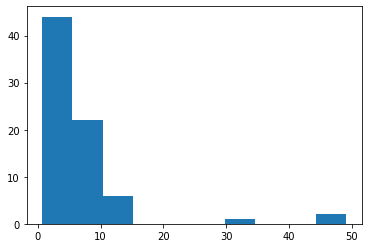

In [12]:
minPs = np.array(minPs)
fig, ax= plt.subplots()
ax.hist(minPs[minPs<400])

In [13]:
# lost 6 more that dropped to < 3 planets with required parameters
Nsys = len(final['hostname'].unique())
Nsys

219

In [15]:
k23 = final[final['hostname']  == 'Kepler-23']
k23[['Delta_i', 'Delta_o', 'Delta_min']]

,Delta_i,Delta_o,Delta_min
13343,NaN,13.470833,13.470833
13357,13.470833,10.816109,10.816109
13365,10.816109,NaN,10.816109


In [13]:
hr858 = final[final['hostname']  == 'HR 858']
hr858[['Delta_i', 'Delta_o', 'Delta_min']]

,Delta_i,Delta_o,Delta_min
2298,NaN,20.134187,20.134187
2299,20.134187,25.310422,20.134187
2301,25.310422,NaN,25.310422


Zhou 2007

In [14]:
e=0.02
ec=0.18
A = -2 + e/ec - 0.27*np.log10(3e-6)
B = (18.7+1.1*np.log10(3e-6))-(16.8+1.2*np.log10(3e-6))*e/ec
A+B*np.log10(15/2.3)

8.963029901448186

In [15]:
kep431 = final[final['hostname']  == 'Kepler-431']
kep431[['Delta_i', 'Delta_o', 'Delta_min', 'my_rade']]

,Delta_i,Delta_o,Delta_min,my_rade
18438,NaN,15.850080,15.850080,1.088
18451,15.850080,17.430506,15.850080,0.720
18460,17.430506,NaN,17.430506,1.307


In [16]:
final['my_compact'].sum()

305.0

In [17]:
data = final[final['my_compact']==1]
data.shape[0]/final.shape[0]

0.391025641025641

* 45% of planets with above cuts are in systems with at least one compact trio (pratios < 2.05)
* Only 26% of planets are in systems where all adjacent pairs have pratios < 2.05

In [18]:
data[data['my_rade'] < 4].shape[0]/data.shape[0]

0.8918032786885246

In [17]:
noeccmask = data['my_ecc'].isnull()
eccmask = ~noeccmask

In [18]:
noeccmask.sum()

260

In [19]:
eccmask.sum()

93

In [20]:
noeccmask = (data['my_ecc'].isnull()) | (data['my_ecc'] + data['my_eccerr1'] > data['ecross_min'])
eccmask = ~noeccmask

In [21]:
noeccmask.sum()

280

In [22]:
eccmask.sum()

73

In [23]:
refs = data[eccmask]['my_ecc_refname'].value_counts()
refs

<a refstr=VAN_EYLEN___ALBRECHT_2015 href=https://ui.adsabs.harvard.edu/abs/2015ApJ...808..126V/abstract target=ref>Van Eylen & Albrecht 2015</a>                    13
<a refstr=VOGT_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017AJ....154..181V/abstract target=ref>Vogt et al. 2017</a>                                       6
<a refstr=BORSATO_ET_AL__2014 href=https://ui.adsabs.harvard.edu/abs/2014A&A...571A..38B/abstract target=ref>Borsato et al. 2014</a>                                 5
<a refstr=JONTOF_HUTTER_ET_AL__2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJ...785...15J/abstract target=ref>Jontof-Hutter et al. 2014</a>                     4
<a refstr=MILLS_ET_AL__2016 href=https://ui.adsabs.harvard.edu/abs/2016Natur.533..509M/abstract target=ref>Mills et al. 2016</a>                                     4
<a refstr=MANN_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017AJ....153..267M/abstract target=ref>Mann et al. 2017</a>                                       

In [24]:
data['my_ttv_flag'] = 0
data['my_td_flag'] = 0
data['my_rv_flag'] = 0
data['my_astro_flag'] = 0

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [27]:
ref = '<a refstr=VAN_EYLEN___ALBRECHT_2015 href=https://ui.adsabs.harvard.edu/abs/2015ApJ...808..126V/abstract target=ref>Van Eylen & Albrecht 2015</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_td_flag'] = 1

<a refstr=VAN_EYLEN___ALBRECHT_2015 href=https://ui.adsabs.harvard.edu/abs/2015ApJ...808..126V/abstract target=ref>Van Eylen & Albrecht 2015</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [25]:
ref = '<a refstr=VOGT_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017AJ....154..181V/abstract target=ref>Vogt et al. 2017</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1

<a refstr=VOGT_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017AJ....154..181V/abstract target=ref>Vogt et al. 2017</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
ref = '<a refstr=BORSATO_ET_AL__2014 href=https://ui.adsabs.harvard.edu/abs/2014A&A...571A..38B/abstract target=ref>Borsato et al. 2014</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1 # photodynamics

<a refstr=BORSATO_ET_AL__2014 href=https://ui.adsabs.harvard.edu/abs/2014A&A...571A..38B/abstract target=ref>Borsato et al. 2014</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
ref = '<a refstr=MILLS_ET_AL__2016 href=https://ui.adsabs.harvard.edu/abs/2016Natur.533..509M/abstract target=ref>Mills et al. 2016</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1 # photodynamics

<a refstr=MILLS_ET_AL__2016 href=https://ui.adsabs.harvard.edu/abs/2016Natur.533..509M/abstract target=ref>Mills et al. 2016</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [29]:
ref = '<a refstr=JONTOF_HUTTER_ET_AL__2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJ...785...15J/abstract target=ref>Jontof-Hutter et al. 2014</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1

<a refstr=JONTOF_HUTTER_ET_AL__2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJ...785...15J/abstract target=ref>Jontof-Hutter et al. 2014</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
ref = '<a refstr=RODRIGUEZ_ET_AL__2018 href=https://ui.adsabs.harvard.edu/abs/2018arXiv180608368R/abstract target=ref>Rodriguez et al. 2018</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1 # photo. Only measure chopping signal, no super period

<a refstr=RODRIGUEZ_ET_AL__2018 href=https://ui.adsabs.harvard.edu/abs/2018arXiv180608368R/abstract target=ref>Rodriguez et al. 2018</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [31]:
ref = '<a refstr=TORRES_ET_AL__2015 href=https://ui.adsabs.harvard.edu/abs/2015ApJ...800...99T/abstract target=ref>Torres et al. 2015</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1 # emin from Kipping 14 rather than full posterior like van Eylen

<a refstr=TORRES_ET_AL__2015 href=https://ui.adsabs.harvard.edu/abs/2015ApJ...800...99T/abstract target=ref>Torres et al. 2015</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [32]:
ref = '<a refstr=GILLON_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017NatAs...1E..56G/abstract target=ref>Gillon et al. 2017</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1 # Also transits of inner two planets (b and c)...probably RVs more important?

<a refstr=GILLON_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017NatAs...1E..56G/abstract target=ref>Gillon et al. 2017</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
ref = '<a refstr=MANN_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017AJ....153..267M/abstract target=ref>Mann et al. 2017</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_td_flag'] = 1 # no significant ttvs

<a refstr=MANN_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017AJ....153..267M/abstract target=ref>Mann et al. 2017</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
ref = '<a refstr=ALMENARA_ET_AL__2018 href=https://ui.adsabs.harvard.edu/abs/2018MNRAS.478..460A/abstract target=ref>Almenara et al. 2018</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1 

<a refstr=ALMENARA_ET_AL__2018 href=https://ui.adsabs.harvard.edu/abs/2018MNRAS.478..460A/abstract target=ref>Almenara et al. 2018</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [33]:
ref = '<a refstr=BUCHHAVE_ET_AL__2016 href=https://ui.adsabs.harvard.edu/abs/2016AJ....152..160B/abstract target=ref>Buchhave et al. 2016</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1 # also tried to set stability constraints with Nbody

<a refstr=BUCHHAVE_ET_AL__2016 href=https://ui.adsabs.harvard.edu/abs/2016AJ....152..160B/abstract target=ref>Buchhave et al. 2016</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [34]:
ref = '<a refstr=ANGLADA_ESCUDE_ET_AL__2013 href=https://ui.adsabs.harvard.edu/abs/2013A%26A...556A.126A/abstract target=ref> Anglada-Escude et al. 2013 </a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1 # 6 planet rv system. Also ran Nbody. Feroz below claims 2 planets.

<a refstr=ANGLADA_ESCUDE_ET_AL__2013 href=https://ui.adsabs.harvard.edu/abs/2013A%26A...556A.126A/abstract target=ref> Anglada-Escude et al. 2013 </a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
ref = '<a refstr=MASUDA_2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJ...783...53M/abstract target=ref> Masuda 2014 </a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1 # photo

<a refstr=MASUDA_2014 href=https://ui.adsabs.harvard.edu/abs/2014ApJ...783...53M/abstract target=ref> Masuda 2014 </a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
ref = '<a refstr=FREUDENTHAL_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019arXiv190706534F/abstract target=ref>Freudenthal et al. 2019</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1 # photo, but measures super period and strong chopping signal (but chopping only constrains mass)

<a refstr=FREUDENTHAL_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019arXiv190706534F/abstract target=ref>Freudenthal et al. 2019</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [40]:
ref = '<a refstr=CORREIA_ET_AL__2010 href=https://ui.adsabs.harvard.edu/abs/2010A%26A...511A..21C/abstract target=ref> Correia et al. 2010 </a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1

<a refstr=CORREIA_ET_AL__2010 href=https://ui.adsabs.harvard.edu/abs/2010A%26A...511A..21C/abstract target=ref> Correia et al. 2010 </a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [42]:
ref = '<a refstr=RIVERA_ET_AL__2010 href=https://ui.adsabs.harvard.edu/abs/2010ApJ...719..890R/abstract target=ref> Rivera et al. 2010 </a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1

<a refstr=RIVERA_ET_AL__2010 href=https://ui.adsabs.harvard.edu/abs/2010ApJ...719..890R/abstract target=ref> Rivera et al. 2010 </a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [43]:
ref = '<a refstr=KOSTOV_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019arXiv190308017K/abstract target=ref>Kostov et al. 2019</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_td_flag'] = 1 # TESS

<a refstr=KOSTOV_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019arXiv190308017K/abstract target=ref>Kostov et al. 2019</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [48]:
ref = '<a refstr=MOTALEBI_ET_AL__2015 href=https://ui.adsabs.harvard.edu/abs/2015A&A...584A..72M/abstract target=ref>Motalebi et al. 2015</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1 # inner planet transits, tons of RV 4 Mearth

<a refstr=MOTALEBI_ET_AL__2015 href=https://ui.adsabs.harvard.edu/abs/2015A&A...584A..72M/abstract target=ref>Motalebi et al. 2015</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [44]:
ref = '<a refstr=DRESSING_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017arXiv170307416D/abstract target=ref>Dressing et al. 2017</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_td_flag'] = 1 # Not much detail. All 4 planets have same e

<a refstr=DRESSING_ET_AL__2017 href=https://ui.adsabs.harvard.edu/abs/2017arXiv170307416D/abstract target=ref>Dressing et al. 2017</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [50]:
ref = '<a refstr=GRAVITY_COLLABORATION_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019A&A...623L..11G/abstract target=ref>Gravity Collaboration et al. 2019</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_astro_flag'] = 1 # astrometry orbitize

<a refstr=GRAVITY_COLLABORATION_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019A&A...623L..11G/abstract target=ref>Gravity Collaboration et al. 2019</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [45]:
ref = '<a refstr=FEROZ__AMP__HOBSON_2014 href=https://ui.adsabs.harvard.edu/abs/2014MNRAS.437.3540F/abstract target=ref>Feroz &amp; Hobson 2014</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1 # claims only 2 planets instead of 6 in anglada-escude

<a refstr=FEROZ__AMP__HOBSON_2014 href=https://ui.adsabs.harvard.edu/abs/2014MNRAS.437.3540F/abstract target=ref>Feroz &amp; Hobson 2014</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [46]:
ref = '<a refstr=ANGLADA_ESCUDE_ET_AL__2012 href=https://ui.adsabs.harvard.edu/abs/2012ApJ...751L..16A/abstract target=ref> Anglada-Escud&eacute; et al. 2012 </a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1 # 6 planet rv system. Also ran Nbody. Feroz above claims 2 planets.

<a refstr=ANGLADA_ESCUDE_ET_AL__2012 href=https://ui.adsabs.harvard.edu/abs/2012ApJ...751L..16A/abstract target=ref> Anglada-Escud&eacute; et al. 2012 </a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [51]:
ref = '<a refstr=DAVID_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019arXiv190209670D/abstract target=ref>David et al. 2019</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_td_flag'] = 1

<a refstr=DAVID_ET_AL__2019 href=https://ui.adsabs.harvard.edu/abs/2019arXiv190209670D/abstract target=ref>David et al. 2019</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [54]:
ref = '<a refstr=VOGT_ET_AL__2015 href=https://ui.adsabs.harvard.edu/abs/2015ApJ...814...12V/abstract target=ref>Vogt et al. 2015</a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_rv_flag'] = 1 # 6 planet RV system  (only 1 met criteria)

<a refstr=VOGT_ET_AL__2015 href=https://ui.adsabs.harvard.edu/abs/2015ApJ...814...12V/abstract target=ref>Vogt et al. 2015</a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [55]:
ref = '<a refstr=LISSAUER_ET_AL__2013 href=https://ui.adsabs.harvard.edu/abs/2013ApJ...770..131L/abstract target=ref> Lissauer et al. 2013 </a>'
print(ref)
data.loc[eccmask & (data[eccmask]['my_ecc_refname']==ref), 'my_ttv_flag'] = 1

<a refstr=LISSAUER_ET_AL__2013 href=https://ui.adsabs.harvard.edu/abs/2013ApJ...770..131L/abstract target=ref> Lissauer et al. 2013 </a>


/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Hadden & Lithwick 2017 did a bunch of TTV systems, but only constrained Z (not individual eccenetricities), so those didn't show up in exoarchive. Flag manually

In [67]:
hadden = pd.read_csv('Hadden17_table2.csv', index_col=0)
hadden.head()

,Res,Delta,Zd,E_Zd,e_Zd,Zproj-d,E_Zproj-d,e_Zproj-d,Zh,E_Zh,e_Zh,Zproj-h,E_Zproj-h,e_Zproj-h,KepID,j,k,n_planets
Pair,,,,,,,,,,,,,,,,,,
Kepler-9 b/c,2:1,0.0126,0.083,0.001,0.001,0.083,0.001,0.001,0.083,0.001,0.001,0.083,0.001,0.001,9,2,1,1
Kepler-11 b/c,5:4,0.0113,0.028,0.010,0.006,0.028,0.010,0.006,0.010,0.004,0.008,0.010,0.004,0.008,11,5,1,4
Kepler-11 c/d,5:3,0.0451,0.013,0.009,0.015,0.001,0.008,0.023,0.001,0.001,0.008,0.000,0.002,0.009,11,5,2,4
Kepler-11 d/e,7:5,0.0074,0.009,0.001,0.001,0.009,0.002,0.001,0.009,0.001,0.001,0.009,0.001,0.002,11,7,2,4
Kepler-11 e/f,3:2,0.0272,0.018,0.004,0.005,0.018,0.004,0.006,0.016,0.004,0.005,0.016,0.004,0.004,11,3,1,4


All flagged systems above were only for ones where eccentricity was measured, so we can just mask the flagged ones by method, and we'll have all the measured eccentricities

In [68]:
ttvmask = data['my_ttv_flag'] == 1
tdmask = data['my_td_flag'] == 1
rvmask = data['my_rv_flag'] == 1
astromask = data['my_astro_flag'] == 1
noeccmask = (data['my_ecc'].isnull()) | (data['my_ecc'] + data['my_eccerr1'] > data['ecross_min'])
eccmask = ~noeccmask

In [69]:
print(ttvmask.sum(), tdmask.sum(), rvmask.sum(), astromask.sum(), noeccmask.sum(), data.shape[0])

29 20 23 1 280 353


In [70]:
ecc = ttvmask.sum()+ tdmask.sum()+ rvmask.sum()+ astromask.sum()
ecc

73

In [71]:
ecc + noeccmask.sum()

353

In [77]:
for i, row in hadden.iterrows():
    sy = i.split()[0]
    for let in i.split()[1].split('/'):
        try:
            data.loc[(data['hostname']==sy)&(data['pl_letter']==let), 'my_ttv_flag'] = 1
        except:
            pass

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [78]:
ttvmask = data['my_ttv_flag'] == 1
tdmask = (data['my_td_flag'] == 1) & (data['my_ttv_flag']==0) # Kep 127b and Kep 138b had td constraints but also in Hadden & Lithwick 17 (with tighter constraints)
rvmask = (data['my_rv_flag'] == 1) & (data['my_ttv_flag']==0) # Kep 51 b had RV constraints but also in Hadden & Lithwick 17 (with tighter constraints)
astromask = data['my_astro_flag'] == 1
noeccmask = ((data['my_ecc'].isnull()) | (data['my_ecc'] + data['my_eccerr1'] > data['ecross_min'])) & (data['my_ttv_flag']==0)
eccmask = ~noeccmask

In [79]:
print(ttvmask.sum(), tdmask.sum(), rvmask.sum(), astromask.sum(), noeccmask.sum(), data.shape[0])

81 18 23 1 230 353


In [80]:
ecc = ttvmask.sum()+ tdmask.sum()+ rvmask.sum()+ astromask.sum()
ecc

123

In [81]:
ecc + noeccmask.sum()

353

In [82]:
data[ttvmask]['hostname'].unique()

array(['K2-266', 'Kepler-11', 'Kepler-114', 'Kepler-122', 'Kepler-127',
       'Kepler-138', 'Kepler-176', 'Kepler-186', 'Kepler-223',
       'Kepler-23', 'Kepler-24', 'Kepler-296', 'Kepler-305', 'Kepler-32',
       'Kepler-33', 'Kepler-444', 'Kepler-49', 'Kepler-51', 'Kepler-54',
       'Kepler-60', 'Kepler-79', 'Kepler-80', 'Kepler-81', 'Kepler-82',
       'Kepler-84', 'Kepler-85'], dtype=object)

In [83]:
data[data['hostname']=='HR 8799']['my_ttv_flag']

2317    0
2311    0
2306    0
2303    0
Name: my_ttv_flag, dtype: int64

<BarContainer object of 19 artists>

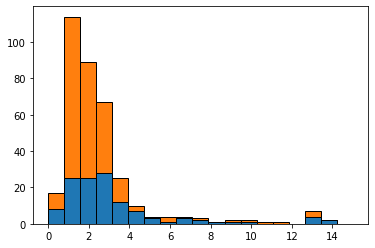

In [84]:
Nbins=20
bins = np.linspace(0, 15, Nbins)
f_ecc, edges = np.histogram(data[eccmask]['my_rade'], bins)
f_noecc, edges = np.histogram(data[noeccmask]['my_rade'], bins)

fig, ax = plt.subplots()
ax.bar(edges[:-1], f_ecc, width=np.diff(edges), edgecolor="black", align="edge")
ax.bar(edges[:-1], f_noecc, width=np.diff(edges), edgecolor="black", align="edge", bottom=f_ecc)

<BarContainer object of 19 artists>

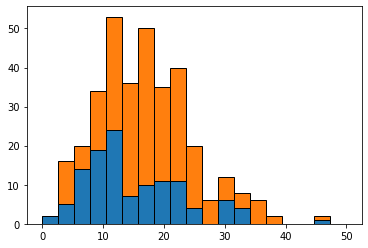

In [85]:
Nbins=20
bins = np.linspace(0, 50, Nbins)
f_ecc, edges = np.histogram(data[eccmask]['Delta_min'], bins)
f_noecc, edges = np.histogram(data[noeccmask]['Delta_min'], bins)

fig, ax = plt.subplots()
ax.bar(edges[:-1], f_ecc, width=np.diff(edges), edgecolor="black", align="edge")
ax.bar(edges[:-1], f_noecc, width=np.diff(edges), edgecolor="black", align="edge", bottom=f_ecc)

In [86]:
def gradient_image(ax, extent, direction=0.3, cmap_range=(0, 1), **kwargs):
    """
    Draw a gradient image based on a colormap.

    Parameters
    ----------
    ax : Axes
        The axes to draw on.
    extent
        The extent of the image as (xmin, xmax, ymin, ymax).
        By default, this is in Axes coordinates but may be
        changed using the *transform* kwarg.
    direction : float
        The direction of the gradient. This is a number in
        range 0 (=vertical) to 1 (=horizontal).
    cmap_range : float, float
        The fraction (cmin, cmax) of the colormap that should be
        used for the gradient, where the complete colormap is (0, 1).
    **kwargs
        Other parameters are passed on to `.Axes.imshow()`.
        In particular useful is *cmap*.
    """
    phi = direction * np.pi / 2
    v = np.array([np.cos(phi), np.sin(phi)])
    X = np.array([[v @ [1, 0], v @ [1, 1]],
                  [v @ [0, 0], v @ [0, 1]]])
    a, b = cmap_range
    X = a + (b - a) / X.max() * X
    im = ax.imshow(X, extent=extent, interpolation='bicubic',
                   vmin=0, vmax=1, **kwargs)
    return im

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


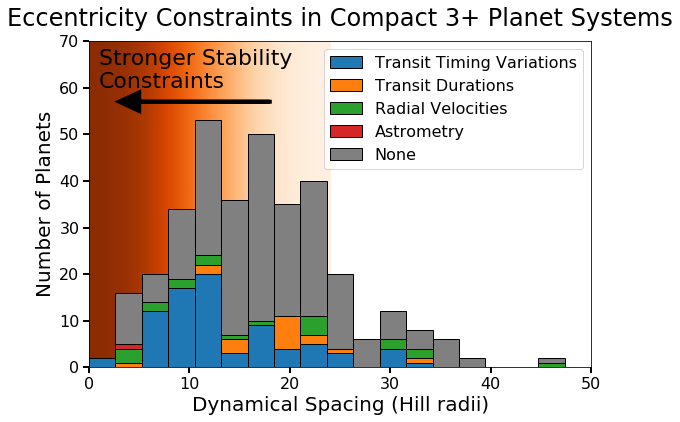

In [87]:
plt.style.use('paper')
Nbins=20
bins = np.linspace(0, 50, Nbins)
f_ttv, edges = np.histogram(data[ttvmask]['Delta_min'], bins)
f_td, edges = np.histogram(data[tdmask]['Delta_min'], bins)
f_rv, edges = np.histogram(data[rvmask]['Delta_min'], bins)
f_astro, edges = np.histogram(data[astromask]['Delta_min'], bins)
f_noecc, edges = np.histogram(data[noeccmask]['Delta_min'], bins)

fig, ax = plt.subplots(figsize=(9,6))

ax.bar(edges[:-1], f_ttv, width=np.diff(edges), edgecolor="black", align="edge", label='Transit Timing Variations')
ax.bar(edges[:-1], f_td, width=np.diff(edges), edgecolor="black", align="edge", bottom=f_ttv, label='Transit Durations')
ax.bar(edges[:-1], f_rv, width=np.diff(edges), edgecolor="black", align="edge", bottom=f_ttv+f_td, label='Radial Velocities')
ax.bar(edges[:-1], f_astro, width=np.diff(edges), edgecolor="black", align="edge", bottom=f_ttv+f_td+f_rv, label='Astrometry')
ax.bar(edges[:-1], f_noecc, width=np.diff(edges), edgecolor="black", align="edge", facecolor='gray', bottom=f_ttv+f_td+f_rv+f_astro, label='None')
ax.legend(fontsize=16)
ax.set_xlabel('Dynamical Spacing (Hill radii)')
ax.set_ylabel('Number of Planets')
ax.set_title('Eccentricity Constraints in Compact 3+ Planet Systems', pad=15)
ax.set_xlim([0,50])

ax.arrow(18, 57, -15, 0, head_width=4, head_length=2, linewidth=4, color='k', length_includes_head=True)
ax.text(1,60, 'Stronger Stability\nConstraints', fontsize=22)
im = gradient_image(ax, direction=1, extent=(0, 24, 0, 70), cmap=plt.cm.Oranges_r, cmap_range=(0., 1), aspect='auto')




In [142]:
data[eccmask][['Kepler' in name for name in data[eccmask]['hostname']]]['hostname']

5076     Kepler-107
5113     Kepler-107
5443      Kepler-11
5457      Kepler-11
5472      Kepler-11
5486      Kepler-11
5493      Kepler-11
5506      Kepler-11
7423     Kepler-127
7432     Kepler-127
8661     Kepler-138
8673     Kepler-138
8699     Kepler-138
12098    Kepler-186
12340    Kepler-197
12353    Kepler-197
12368    Kepler-197
12443     Kepler-20
12454     Kepler-20
12487     Kepler-20
13130    Kepler-223
13147    Kepler-223
13157    Kepler-223
13159    Kepler-223
15302    Kepler-296
15323    Kepler-296
16557    Kepler-338
16534    Kepler-338
16544    Kepler-338
17290     Kepler-37
18641    Kepler-445
18653    Kepler-445
18659    Kepler-445
19367     Kepler-51
19386     Kepler-51
19391     Kepler-51
22642     Kepler-79
22650     Kepler-79
22661     Kepler-79
22675     Kepler-79
23060     Kepler-82
23069     Kepler-82
23097     Kepler-82
24163     Kepler-92
24182     Kepler-92
Name: hostname, dtype: object

<BarContainer object of 19 artists>

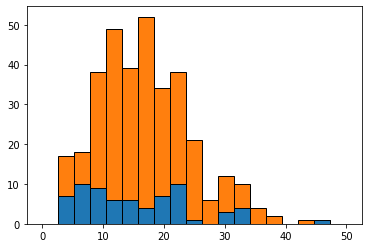

In [24]:
Nbins=20
bins = np.linspace(0, 50, Nbins)
f_ttv, edges = np.histogram(data[ttvmask]['Delta_min'], bins)
f_td, edges = np.histogram(data[tdmask]['Delta_min'], bins)
f_rv, edges = np.histogram(data[rvmask]['Delta_min'], bins)
f_astro, edges = np.histogram(data[astromask]['Delta_min'], bins)
f_noecc, edges = np.histogram(data[noeccmask]['Delta_min'], bins)

fig, ax = plt.subplots()
ax.bar(edges[:-1], f_ttv, width=np.diff(edges), edgecolor="black", align="edge", legend='Transit Timing Variations')
ax.bar(edges[:-1], f_td, width=np.diff(edges), edgecolor="black", align="edge", legend='Transit Durations')
ax.bar(edges[:-1], f_rv, width=np.diff(edges), edgecolor="black", align="edge", legend='Radial Velocities')
ax.bar(edges[:-1], f_astro, width=np.diff(edges), edgecolor="black", align="edge", legend='Astrometry')
ax.bar(edges[:-1], f_noecc, width=np.diff(edges), edgecolor="black", align="edge", bottom=f_ecc)

In [25]:
data.shape

(353, 321)

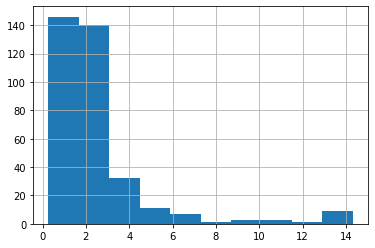

In [26]:
data['my_rade'].hist()

* Check Sam's paper

In [31]:
data[eccmask]['hostname'].unique()

array(['GJ 667 C', 'GJ 876', 'HD 219134', 'HD 34445', 'HR 8799', 'K2-266',
       'K2-72', 'Kepler-107', 'Kepler-11', 'Kepler-127', 'Kepler-138',
       'Kepler-186', 'Kepler-197', 'Kepler-20', 'Kepler-223', 'Kepler-23',
       'Kepler-296', 'Kepler-338', 'Kepler-37', 'Kepler-444',
       'Kepler-445', 'Kepler-51', 'Kepler-79', 'Kepler-82', 'Kepler-92',
       'L 98-59', 'V1298 Tau'], dtype=object)

In [29]:
data[eccmask][data[eccmask]['hostname']=='Kepler-79']['my_ttv_flag'] = 1

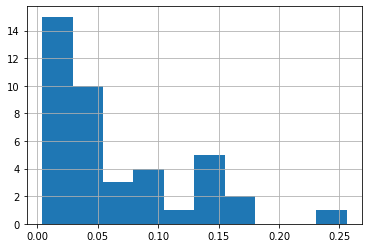

In [373]:
data[data['my_ecc_rvflag'] == 1]['my_ecc'].hist()

In [309]:
dfunique[eccmask & (dfunique['my_rade'] < 1.5)]['pl_name']

43           47 UMa b
46           47 UMa c
47           47 UMa d
98           61 Vir b
99           61 Vir c
100          61 Vir d
379          GJ 163 b
380          GJ 163 c
381          GJ 163 d
384          GJ 180 b
385          GJ 180 c
386          GJ 180 d
395         GJ 3138 b
396         GJ 3138 c
397         GJ 3138 d
403         GJ 3293 b
406         GJ 3293 c
407         GJ 3293 d
408         GJ 3293 e
437          GJ 433 b
438          GJ 433 c
440          GJ 433 d
464          GJ 581 b
467          GJ 581 c
471          GJ 581 e
477        GJ 667 C b
484        GJ 667 C c
485        GJ 667 C e
486        GJ 667 C f
487        GJ 667 C g
             ...     
18302     Kepler-42 b
18308     Kepler-42 c
18317     Kepler-42 d
18602    Kepler-444 b
18605    Kepler-444 c
18611    Kepler-444 d
18627    Kepler-444 e
18630    Kepler-444 f
18659    Kepler-445 d
18759    Kepler-450 d
20067     Kepler-56 d
21133     Kepler-65 b
21473     Kepler-68 c
25017       L 98-59 b
25019     

In [262]:
%%time
rvunique = pd.DataFrame()
for name in rv['pl_name'].unique():
    rvunique=rvunique.append(singlerowwithradius(rv, name))

HD 160691 d failed
HD 160691 e failed
HD 181433 c failed
HD 181433 d failed
HD 69830 b failed
HD 69830 c failed
HD 69830 d failed
CPU times: user 20 s, sys: 44.2 ms, total: 20 s
Wall time: 20 s


In [256]:
%%time
tranunique = pd.DataFrame()
for name in tran['pl_name'].unique():
    tranunique=tranunique.append(singlerowwithradius(tran, name))

CPU times: user 52.1 s, sys: 103 ms, total: 52.2 s
Wall time: 52.3 s


In [257]:
%%time
bothunique = pd.DataFrame()
for name in both['pl_name'].unique():
    bothunique=bothunique.append(singlerowwithradius(both, name))

CPU times: user 9.3 s, sys: 29.3 ms, total: 9.33 s
Wall time: 9.35 s


In [258]:
Nrv =rvunique.shape[0]
Ntran = tranunique.shape[0]
Nboth = bothunique.shape[0]
Nplanets = Nrv + Ntran + Nboth
print(Ntran,Nrv,Nboth,Nplanets)

578 144 102 824


In [244]:
rvunique.shape

(144, 297)

In [246]:
len(rv['pl_name'].unique())

151

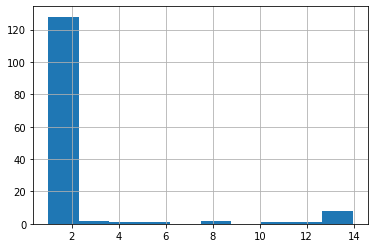

In [254]:
rvunique['my_rade'].hist()

In [241]:
name = 'HD 160691 d'
copies = rv[rv['pl_name']==name]
copies[['pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_masse', 'pl_masseerr1', 'pl_masseerr2','pl_msinie', 'pl_msinieerr1', 'pl_msinieerr2']]

,pl_rade,pl_radeerr1,pl_radeerr2,pl_masse,pl_masseerr1,pl_masseerr2,pl_msinie,pl_msinieerr1,pl_msinieerr2
1342,NaN,NaN,NaN,NaN,NaN,NaN,10.5547,NaN,NaN
1343,NaN,NaN,NaN,NaN,NaN,NaN,14.0000,NaN,NaN
1344,NaN,NaN,NaN,NaN,NaN,NaN,10.1700,NaN,NaN


In [216]:
rv[rv['pl_msinie'].isnull()]['pl_masse']

55        263.9785
63        266.9660
64        254.2500
67         54.4738
70         56.6985
77       1232.4930
78       1226.7700
93         47.0051
94         44.8120
514       845.3000
515       839.0400
517       804.0760
519       723.2235
522       226.9846
523       273.3200
524       266.2000
526       251.0750
528         6.8300
531         7.5300
532         7.4900
533        14.6000
534        16.5800
1684       16.1700
1686        7.3000
12175      13.1000
12176    1906.9000
12177      22.5000
13975      89.9000
19018     657.0000
21488     267.0000
Name: pl_masse, dtype: float64

In [ ]:
%%time
sample=rv
rvunique = pd.DataFrame(columns = df.columns)
for name in sample['pl_name'].unique():
    copies = sample[sample['pl_name']==name]
    try:
        unique=unique.append(copies[copies['pl_radeerr1'] == copies['pl_radeerr1'].min()].iloc[0])
    except:
        ctr += 1

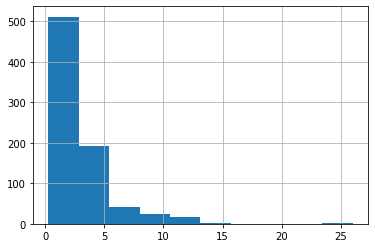

In [197]:
both['pl_rade'].hist()

In [198]:
both['pl_rade'].isnull().sum()

150

In [199]:
both.shape

(937, 296)

In [ ]:
%%time
unique = pd.DataFrame(columns = df.columns)
ctr = 0
for name in df['pl_name'].unique():
    copies = df[df['pl_name']==name]
    try:
        unique=unique.append(copies[copies['pl_radeerr1'] == copies['pl_radeerr1'].min()].iloc[0])
    except:
        ctr += 1

In [159]:
detection_flags = df.columns[["flag" in col for col in df.columns]]

In [160]:
test = rv[(rv['tran_flag']==False)&(rv['ima_flag']==False)]
test[~test['pl_rade'].isnull()][detection_flags]

,default_flag,rv_flag,pul_flag,ptv_flag,tran_flag,ast_flag,obm_flag,micro_flag,etv_flag,ima_flag,dkin_flag,pl_controv_flag,ttv_flag
1094,0,1,0,0,0,0,0,0,0,0,0,0,0
1684,1,1,0,0,0,0,0,0,0,0,0,0,0
1686,1,1,0,0,0,0,0,0,0,0,0,1,0
2004,0,1,0,0,0,0,0,0,0,0,0,0,0


In [100]:
Nplanets = len(df['pl_name'].unique())
Nplanets

4141

In [133]:
%%time
unique = pd.DataFrame(columns = df.columns)
ctr = 0
for name in df['pl_name'].unique():
    copies = df[df['pl_name']==name]
    try:
        unique=unique.append(copies[copies['pl_radeerr1'] == copies['pl_radeerr1'].min()].iloc[0])
    except:
        ctr += 1

CPU times: user 2min 21s, sys: 2.35 s, total: 2min 24s
Wall time: 1min 50s


In [134]:
unique.shape

(3195, 296)

In [101]:
ecc = df[(df['pl_orbeccen'] > 0) & (~df['pl_orbeccenerr1'].isnull()) & (~df['pl_orbeccenerr2'].isnull())]
len(ecc['pl_name'].unique())

1166

In [119]:
eccunique = pd.DataFrame(columns = df.columns)

for name in ecc['pl_name'].unique():
    copies = ecc[ecc['pl_name']==name]
    eccunique=eccunique.append(copies[copies['pl_orbeccenerr1'] == copies['pl_orbeccenerr1'].min()].iloc[0])

In [120]:
eccunique.shape

(1166, 296)

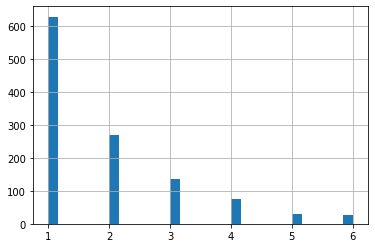

In [122]:
eccunique['sy_pnum'].hist(bins=30)

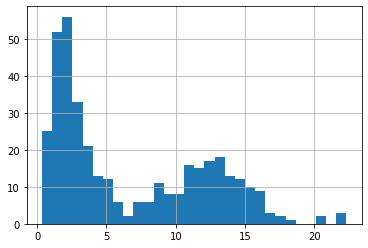

In [123]:
eccunique['pl_rade'].hist(bins=30)

In [124]:
small =  eccunique[eccunique['pl_rade'] <4]

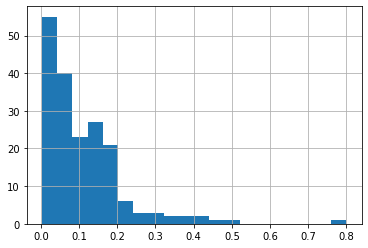

In [126]:
small['pl_orbeccen'].hist(bins=20)

In [131]:
two = eccunique[eccunique['sy_pnum'] > 1]
three = eccunique[eccunique['sy_pnum'] > 2]

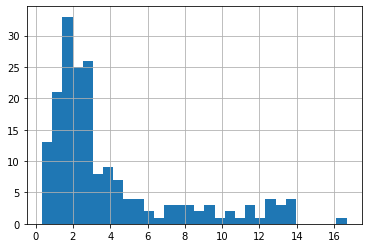

In [129]:
two['pl_rade'].hist(bins=30)

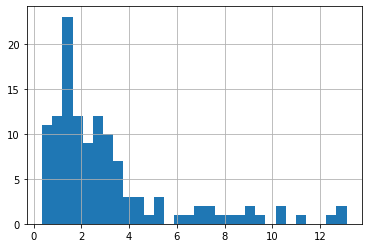

In [132]:
three['pl_rade'].hist(bins=30)

In [88]:
df[df['pl_name']=='GJ 436 b'][['pl_orbeccen', 'pl_orbeccenerr1','pl_orbeccenerr2', 'pl_refname']]

,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_refname
441,NaN,NaN,NaN,<a refstr=TORRES_ET_AL__2008 href=https://ui.a...
442,0.16160,0.00410,-0.00320,<a refstr=LANOTTE_ET_AL__2014 href=https://ui....
443,0.15000,0.01200,-0.01200,<a refstr=TURNER_ET_AL__2016 href=https://ui.a...
444,NaN,NaN,NaN,<a refstr=CACERES_ET_AL__2009 href=https://ui....
445,NaN,NaN,NaN,<a refstr=SOUTHWORTH_2010 href=https://ui.adsa...
446,0.14950,0.01600,-0.00970,<a refstr=KNUTSON_ET_AL__2014 href=https://ui....
447,0.13827,0.00018,-0.00018,<a refstr=MACIEJEWSKI_ET_AL__2014 href=https:/...
448,NaN,NaN,NaN,<a refstr=SHPORER_ET_AL__2009 href=https://ui....
449,NaN,NaN,NaN,<a refstr=BALUEV_ET_AL__2015 href=https://ui.a...
450,NaN,NaN,NaN,<a refstr=PONT_ET_AL__2009 href=https://ui.ads...


In [94]:
df[df['pl_name']=='Kepler-79 b'][['pl_orbeccen', 'pl_orbeccenerr1','pl_orbeccenerr2', 'pl_refname']]

,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_refname
22633,NaN,NaN,NaN,<a refstr=HOLCZER_ET_AL__2016 href=https://ui....
22634,NaN,NaN,NaN,<a refstr=XIE_2013 href=https://ui.adsabs.harv...
22635,0.000,NaN,NaN,<a refstr=Q1_Q17_DR24_KOI_TABLE href=https://e...
22636,NaN,NaN,NaN,<a refstr=BERGER_ET_AL__2018 href=https://ui.a...
22637,0.000,NaN,NaN,<a refstr=Q1_Q8_KOI_TABLE href=https://exoplan...
22638,0.000,NaN,NaN,<a refstr=Q1_Q16_KOI_TABLE href=https://exopla...
22639,0.000,NaN,NaN,<a refstr=Q1_Q17_DR25_KOI_TABLE href=https://e...
22640,NaN,NaN,NaN,<a refstr=MORTON_ET_AL__2016 href=https://ui.a...
22641,NaN,NaN,NaN,<a refstr=HADDEN_ET_AL__2014 href=https://ui.a...
22642,0.015,0.012,-0.006,<a refstr=JONTOF_HUTTER_ET_AL__2014 href=https...


In [4]:
len(df['pl_name'].unique())

4141

In [74]:
three =  df[df['sy_pnum'] > 0]

In [75]:
len(three['hostname'].unique())

3078

In [76]:
len(three['pl_name'].unique())

4141

In [77]:
ecc = three[three['pl_orbeccen'] > 0]

In [78]:
smallecc= ecc[ecc['pl_rade'] < 20]

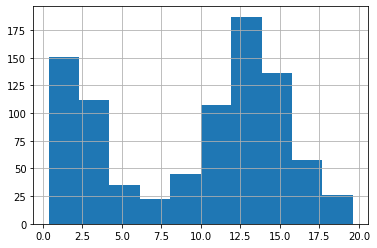

In [79]:
smallecc['pl_rade'].hist()

In [69]:
len(smallecc['pl_refname'].unique())

9

In [41]:
smallecc[['hostname', 'pl_name', 'pl_refname']]

,hostname,pl_name,pl_refname
79,55 Cnc,55 Cnc e,<a refstr=DEMORY_ET_AL__2011 href=https://ui.a...
201,CoRoT-22,CoRoT-22 b,<a refstr=MOUTOU_ET_AL__2014 href=https://ui.a...
290,EPIC 211822797,EPIC 211822797 b,<a refstr=MANN_ET_AL__2017 href=https://ui.ads...
291,EPIC 211822797,EPIC 211822797 b,<a refstr=DRESSING_ET_AL__2017 href=https://ui...
313,EPIC 212737443,EPIC 212737443 b,<a refstr=HERATH_ET_AL__2019 href=https://ui.a...
314,EPIC 212737443,EPIC 212737443 c,<a refstr=HERATH_ET_AL__2019 href=https://ui.a...
328,EPIC 220674823,EPIC 220674823 c,<a refstr=GUENTHER_ET_AL__2017 href=https://ui...
336,EPIC 249893012,EPIC 249893012 b,<a refstr=HIDALGO_ET_AL__2020 href=https://ui....
337,EPIC 249893012,EPIC 249893012 c,<a refstr=HIDALGO_ET_AL__2020 href=https://ui....
338,EPIC 249893012,EPIC 249893012 d,<a refstr=HIDALGO_ET_AL__2020 href=https://ui....


In [39]:
smallecc[smallecc['hostname']=='EPIC 211822797']

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,default_flag,sy_snum,sy_pnum,...,sy_kepmagerr1,sy_kepmagerr2,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_ntranspec,st_nspec
290,291,EPIC 211822797 b,EPIC 211822797,b,NaN,NaN,TIC 337632006 b,0,1,1,...,NaN,NaN,2017-12-12,2017-02,2017-12-12,1,0,0,0,0
291,292,EPIC 211822797 b,EPIC 211822797,b,NaN,NaN,TIC 337632006 b,1,1,1,...,NaN,NaN,2017-12-12,2017-03,2017-12-12,1,0,0,0,0


In [37]:
len(smallecc['hostname'].unique())

138

In [33]:
smallecc['pl_orbeccen']

34       0.26000
79       0.06100
152      0.03600
154      0.07100
156      0.52400
157      0.53000
160      0.36000
163      0.07000
165      0.05000
169      0.06700
171      0.03600
173      0.33000
174      0.37000
175      0.08100
180      0.08000
181      0.02500
183      0.05600
184      0.04700
185      0.02400
186      0.01430
193      0.57500
196      0.56200
200      0.39000
201      0.07700
202      0.16000
203      0.16000
208      0.22000
209      0.41000
211      0.03400
212      0.06500
          ...   
26069    0.31000
26072    0.30000
26073    0.31000
26077    0.02000
26078    0.00200
26079    0.07000
26081    0.06600
26085    0.12000
26087    0.07700
26097    0.13000
26099    0.19280
26100    0.19300
26107    0.06400
26109    0.13000
26112    0.01800
26115    0.11000
26118    0.01900
26121    0.07000
26123    0.01000
26127    0.10000
26129    0.35000
26138    0.01900
26148    0.00600
26153    0.00600
26165    0.26000
26167    0.27587
26168    0.29000
26170    0.003

In [4]:
gold = df[(df['tran_flag']==1) & (df['pl_rade'] < 1.5) & (df['pl_radeerr1'] < 0.05*df['pl_rade']) & (df['sy_pnum'] > 1)]

In [5]:
gold['hostname'].unique()

array(['GJ 9827', 'K2-141', 'K2-229', 'K2-233', 'Kepler-10', 'Kepler-100',
       'Kepler-102', 'Kepler-1047', 'Kepler-107', 'Kepler-114',
       'Kepler-118', 'Kepler-124', 'Kepler-1254', 'Kepler-126',
       'Kepler-127', 'Kepler-128', 'Kepler-130', 'Kepler-138',
       'Kepler-1398', 'Kepler-141', 'Kepler-144', 'Kepler-1542',
       'Kepler-167', 'Kepler-174', 'Kepler-181', 'Kepler-185',
       'Kepler-186', 'Kepler-190', 'Kepler-197', 'Kepler-20',
       'Kepler-205', 'Kepler-206', 'Kepler-211', 'Kepler-213',
       'Kepler-215', 'Kepler-220', 'Kepler-225', 'Kepler-240',
       'Kepler-249', 'Kepler-250', 'Kepler-26', 'Kepler-285',
       'Kepler-292', 'Kepler-303', 'Kepler-316', 'Kepler-32',
       'Kepler-326', 'Kepler-327', 'Kepler-330', 'Kepler-332',
       'Kepler-333', 'Kepler-339', 'Kepler-342', 'Kepler-345',
       'Kepler-36', 'Kepler-363', 'Kepler-367', 'Kepler-369', 'Kepler-37',
       'Kepler-378', 'Kepler-381', 'Kepler-383', 'Kepler-390',
       'Kepler-398', 'Kepler-4

In [6]:
golddf = pd.DataFrame(columns = df.columns)

for ID in gold['hostname'].unique():
    system = df[df['hostname'] == ID].sort_values('pl_orbper')
    for name in system['pl_name'].unique():
        copies = system[system['pl_name']==name]
        try:
            golddf=golddf.append(copies[copies['pl_radeerr1'] == copies['pl_radeerr1'].min()].iloc[0])
        except:
            pass # errors are NaN

In [7]:
golddf

,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,default_flag,sy_snum,sy_pnum,...,sy_kepmagerr1,sy_kepmagerr2,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_ntranspec,st_nspec
537,538,GJ 9827 b,GJ 9827,b,NaN,HIP 115752 b,TIC 301289516 b,1,1,3,...,NaN,NaN,2019-08-23,2019-04,2019-08-23,2,0,0,0,0
541,542,GJ 9827 c,GJ 9827,c,NaN,HIP 115752 c,TIC 301289516 c,1,1,3,...,NaN,NaN,2019-08-23,2019-04,2019-08-23,2,0,0,0,0
545,546,GJ 9827 d,GJ 9827,d,NaN,HIP 115752 d,TIC 301289516 d,1,1,3,...,NaN,NaN,2019-08-23,2019-04,2019-08-23,2,0,0,0,0
2580,2581,K2-141 b,K2-141,b,NaN,NaN,TIC 301235044 b,0,1,2,...,NaN,NaN,2019-08-23,2019-08,2019-08-23,0,0,0,0,0
2582,2583,K2-141 c,K2-141,c,NaN,NaN,TIC 301235044 c,1,1,2,...,NaN,NaN,2018-01-16,2018-03,2018-01-16,1,0,0,0,0
3091,3092,K2-229 b,K2-229,b,NaN,NaN,TIC 98720809 b,0,1,2,...,NaN,NaN,2019-08-23,2019-08,2019-08-23,0,0,0,0,0
3095,3096,K2-229 c,K2-229,c,NaN,NaN,TIC 98720809 c,0,1,2,...,NaN,NaN,2018-07-12,2018-03,2018-07-12,0,0,0,0,0
3108,3109,K2-233 b,K2-233,b,NaN,NaN,TIC 428820090 b,1,1,3,...,NaN,NaN,2018-04-25,2018-03,2018-04-25,1,0,0,0,0
3109,3110,K2-233 c,K2-233,c,NaN,NaN,TIC 428820090 c,1,1,3,...,NaN,NaN,2018-04-25,2018-03,2018-04-25,1,0,0,0,0
3110,3111,K2-233 d,K2-233,d,NaN,NaN,TIC 428820090 d,1,1,3,...,NaN,NaN,2018-04-25,2018-03,2018-04-25,1,0,0,0,0


In [8]:
golddf.shape

(243, 296)

In [9]:
adj = pd.DataFrame(columns = ["R", "Rnext", "R_err1", "R_err2"])
for ID in golddf['hostname'].unique():
    s = golddf[golddf['hostname'] == ID]
    for i in range(s.shape[0]-1):
        if ~np.isnan(s.iloc[i]['pl_rade']) and ~np.isnan(s.iloc[i+1]['pl_rade']): # both have measured radii
            if s.iloc[i]['pl_rade'] < 16 and s.iloc[i+1]['pl_rade'] < 16: # Smaller than 16  Earth radii
                    adj = adj.append(pd.Series({'R':s.iloc[i]['pl_rade'], 'Rnext':s.iloc[i+1]['pl_rade'], 'R_err1':s.iloc[i]['pl_radeerr1'], 'R_err2':s.iloc[i]['pl_radeerr2']}), ignore_index=True)

Text(0.3, 6, 'Pearson R = 0.21')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


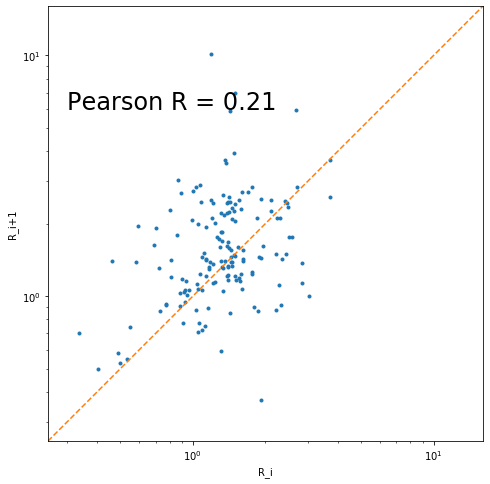

In [10]:
from numpy import random
from scipy.stats import pearsonr
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(adj['R'], adj['Rnext'], '.')
ax.set_xlim([0.25,16])
ax.set_ylim([0.25,16])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
ax.set_xlabel('R_i')
ax.set_ylabel('R_i+1')
ax.plot(np.linspace(0.25,16,10), np.linspace(0.25,16,10), '--')
ax.text(0.3, 6, 'Pearson R = {0:.2f}'.format(pearsonr(adj['R'], adj['Rnext'])[0]), fontsize=24)

In [92]:
trappist = pd.DataFrame(columns = df.columns)

system = df[df['hostname'] == 'TRAPPIST-1'].sort_values('pl_orbper')
for name in system['pl_name'].unique():
    copies = system[system['pl_name']==name]
    try:
        trappist=trappist.append(copies[copies['pl_radeerr1'] == copies['pl_radeerr1'].min()].iloc[0])
    except:
        pass # errors are NaN

In [96]:
adj = pd.DataFrame(columns = ["R", "Rnext", "R_err1", "R_err2"])
for ID in trappist['hostname'].unique():
    s = trappist[trappist['hostname'] == ID]
    for i in range(s.shape[0]-1):
        if ~np.isnan(s.iloc[i]['pl_rade']) and ~np.isnan(s.iloc[i+1]['pl_rade']): # both have measured radii
            if s.iloc[i]['pl_rade'] < 16 and s.iloc[i+1]['pl_rade'] < 16: # Smaller than 16  Earth radii
                    adj = adj.append(pd.Series({'R':s.iloc[i]['pl_rade'], 'Rnext':s.iloc[i+1]['pl_rade'], 'R_err1':s.iloc[i]['pl_radeerr1'], 'R_err2':s.iloc[i]['pl_radeerr2']}), ignore_index=True)

Text(0.3, 6, 'Pearson R = -0.18')

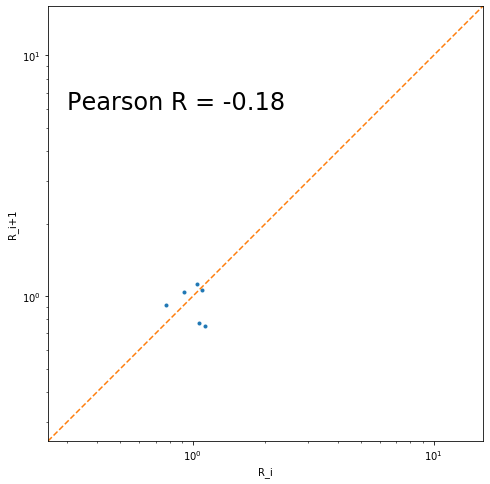

In [97]:
from numpy import random
from scipy.stats import pearsonr
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(adj['R'], adj['Rnext'], '.')
ax.set_xlim([0.25,16])
ax.set_ylim([0.25,16])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('equal')
ax.set_xlabel('R_i')
ax.set_ylabel('R_i+1')
ax.plot(np.linspace(0.25,16,10), np.linspace(0.25,16,10), '--')
ax.text(0.3, 6, 'Pearson R = {0:.2f}'.format(pearsonr(adj['R'], adj['Rnext'])[0]), fontsize=24)